In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
c = nmp.connectomics.npt_client()

In [3]:
# load eb coords
ebcoords = nmp.connectomics.EBCoordinateSystem()
eb = neu.fetch_roi("EB")
eb.vertices = ebcoords.eb_vertices
eb.vertices[:,1] = -eb.vertices[:,1]  # flip y axis to match EB coordinates
eb.vertices[:,2] = -eb.vertices[:,2]

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/connectomics.py:150: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=92). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  self._xsec_rad_spline = sp.interpolate.LSQBivariateSpline(eb_phase, xsec_phase, xsec_rad, knots, knots)


In [4]:
def add_eb_coords(syn_df, ebcoords, type='post'):
    syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']] = ebcoords.change_of_basis(syn_df.loc[:,[f'x_{type}', f'y_{type}', f'z_{type}']].values)
    syn_df.loc[:, ['y_eb', 'z_eb']] = -1*syn_df.loc[:,['y_eb','z_eb']]
    phase, radius = ebcoords.get_circ_coordinates(syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']].values)
    syn_df['phase'], syn_df['radius'] = phase, radius
    syn_df['radius_scaled'] = ebcoords.scale_radius(syn_df['phase'],syn_df['radius'])
    syn_df['xsec_phase'], syn_df['xsec_radius'] = ebcoords.get_xsec_coords(syn_df['phase'],syn_df['radius'], syn_df['z_eb'])
    syn_df['xsec_radius_scaled'] = ebcoords.scale_xsec_rad(syn_df['phase'], 
                                                            syn_df['xsec_phase'], 
                                                            syn_df['xsec_radius'])

    syn_df['xsec_x'] = syn_df['xsec_radius']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y'] = syn_df['xsec_radius']*np.sin(syn_df['xsec_phase'])
    syn_df['xsec_x_scaled'] = syn_df['xsec_radius_scaled']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y_scaled'] = syn_df['xsec_radius_scaled']*np.sin(syn_df['xsec_phase'])

def change_of_basis(navis_skeleton):
    nodes = navis_skeleton.nodes.copy()
    nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
    nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
    nodes.loc[:,'z'] = -nodes.loc[:,'z']
    nodes.head()
    navis_skeleton.set_neuron_attributes(nodes,name='nodes')
    return navis_skeleton

In [5]:
# load example ER4d, EPG and an EL that connects them
er4ds, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'ER4d'))


els, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EL'))
epgs, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EPG'))

example_er4d_bodyId = er4ds['bodyId'].iloc[3]
neuron_df, conn_df = neu.queries.fetch_adjacencies(els['bodyId'], example_er4d_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_el_bodyId = conn_df['bodyId_pre'].iloc[0].copy()

neuron_df, conn_df = neu.queries.fetch_adjacencies(epgs['bodyId'], example_el_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_epg_bodyID = conn_df['bodyId_pre'].iloc[0].copy()



In [6]:
er4d_skel = neu.fetch_skeletons(example_er4d_bodyId)
er4d_skel = change_of_basis(er4d_skel)

el_skel = neu.fetch_skeletons(example_el_bodyId)
el_skel = change_of_basis(el_skel)

epg_skel = neu.fetch_skeletons(example_epg_bodyID)
epg_skel = change_of_basis(epg_skel)

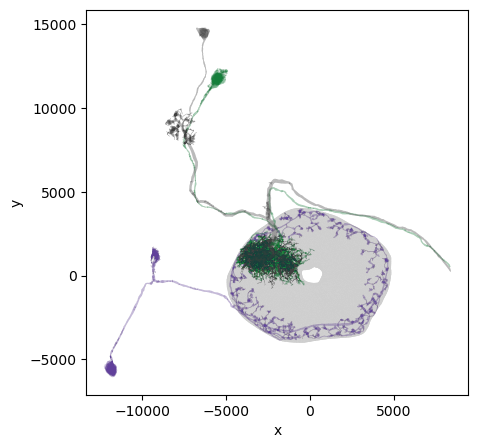

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel, el_skel, epg_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8), 
                       plt.cm.Greens(.8),
                       plt.cm.Greys(.8),
                       plt.cm.Greys(.3)),
                alpha=.2,
                radius=True,
                ax=ax,
            )
ax.grid(False)

In [8]:

er4d_epg_synapses = neu_orig.fetch_synapse_connections(example_er4d_bodyId,
                                                       epgs['bodyId'], #example_epg_bodyID,
                                                       neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(er4d_epg_synapses, ebcoords, type='pre')

el_er4d_synapses = neu_orig.fetch_synapse_connections(els['bodyId'], #example_el_bodyId,
                                                      example_er4d_bodyId,
                                                      neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(el_er4d_synapses, ebcoords, type='post')

# er4d_neu_skel = neu_orig.fetch_skeleton(example_er4d_bodyId)
# er4d_neu_skel = neu_orig.skeleton.upsample_skeleton(er4d_neu_skel)




  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

(-5000.0, 5000.0)

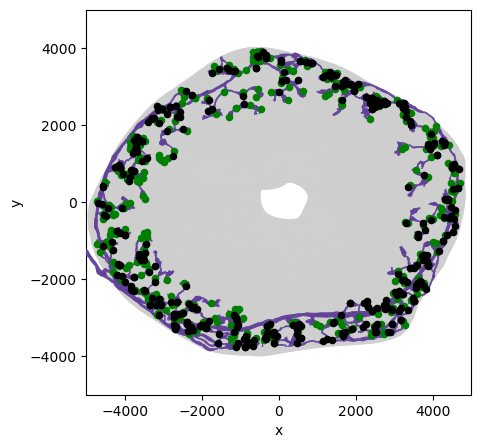

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)

ax.scatter(er4d_epg_synapses.loc[:,'x_eb'], 
           er4d_epg_synapses.loc[:,'y_eb'],
           s=20, color='black',zorder=101) #plt.cm.Greys(.8))

ax.scatter(el_er4d_synapses.loc[:,'x_eb'],
           el_er4d_synapses.loc[:,'y_eb'],
           s=20, color='green',zorder=100) #color=plt.cm.Greens(.8))

ax.set_xlim([-5000, 5000])
ax.set_ylim([-5000,5000])

In [17]:
# get synapses from example ER4d to EPG and EL to example ER4d
er4d_epg_synapses = neu_orig.fetch_synapse_connections(example_er4d_bodyId,
                                                       epgs['bodyId'], #example_epg_bodyID,
                                                       neu_orig.SynapseCriteria(rois='EB'))

el_er4d_synapses = neu_orig.fetch_synapse_connections(els['bodyId'], #example_el_bodyId,
                                                      example_er4d_bodyId,
                                                      neu_orig.SynapseCriteria(rois='EB'))

er4d_epg_synapses['type'] = 'pre'
er4d_epg_synapses['x'], er4d_epg_synapses['y'], er4d_epg_synapses['z'] = er4d_epg_synapses['x_pre'], er4d_epg_synapses['y_pre'], er4d_epg_synapses['z_pre']


el_er4d_synapses['type'] = 'post'
el_er4d_synapses['x'], el_er4d_synapses['y'], el_er4d_synapses['z'] = el_er4d_synapses['x_post'], el_er4d_synapses['y_post'], el_er4d_synapses['z_post']
syns = pd.concat((el_er4d_synapses, er4d_epg_synapses), ignore_index=True)

# attach synapses to skeleton

er4d_skel = neu_orig.fetch_skeleton(example_er4d_bodyId, heal=True,with_distances=True)
er4d_skel = neu_orig.upsample_skeleton(er4d_skel, 2)
er4d_skel = neu_orig.attach_synapses_to_skeleton(er4d_skel, syns)
# er4d_skel = neu_orig.attach_synapses_to_skeleton(er4d_skel, el_er4d_synapses)


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

In [18]:
er4d_skel['structure'].unique()

['neurite', 'post', 'pre']
Categories (3, object): ['neurite', 'post', 'pre']

In [19]:
# make dictionary with rowID and structure
struct_dict = {}
for _, row in er4d_skel.iterrows():
    struct_dict[row['rowId']]=row['structure']

In [20]:
er4d_nx = neu_orig.skeleton_df_to_nx(er4d_skel, with_distances=True,directed=False)
nx.set_node_attributes(er4d_nx, struct_dict, 'structure')

In [21]:
pre_syns = er4d_skel.loc[er4d_skel['structure']=='pre']
pre_syns

,rowId,x,y,z,radius,link,structure
161273,161274,26974.0,25616.0,17032.0,0.0,71216,pre
161274,161275,26562.0,25750.0,16925.0,0.0,70825,pre
161275,161276,26667.0,25713.0,16938.0,0.0,70793,pre
161276,161277,27202.0,24548.0,16986.0,0.0,66965,pre
161277,161278,27364.0,25037.0,16846.0,0.0,68209,pre
...,...,...,...,...,...,...,...
161632,161633,29232.0,25626.0,23132.0,0.0,1653,pre
161633,161634,29145.0,26608.0,22873.0,0.0,31705,pre
161634,161635,29188.0,26461.0,22813.0,0.0,31784,pre
161635,161636,29532.0,26431.0,22392.0,0.0,34440,pre


In [15]:
list(er4d_nx.nodes(data='True'))[:10]

[(1, None),
 (2, None),
 (3, None),
 (4, None),
 (5, None),
 (6, None),
 (7, None),
 (8, None),
 (9, None),
 (10, None)]

In [105]:
# from skeleton_df find presynapses
post_syns = er4d_skel.loc[er4d_skel['structure']=='post']
post_nodes = []
for _, row in post_syns.iterrows():
    # rowid = row['rowId']
    post_nodes.append(row['rowId'])

# for each presynapse
pre_node= pre_syns['rowId'].iloc[2]
output = nx.multi_source_dijkstra(er4d_nx, post_nodes, target=pre_node)

In [106]:
print(output[0])
print(output[1][0], output[1][-1])
print(pre_node)

46
161164 161276
161276


In [93]:
for post in post_nodes:
    try:
        nx.shortest_path_length(er4d_nx, source=pre_node, target=post, weight='distance')
        print(post)
    except:
        pass


160938
160939
160940
160941
160942
160943
160944
160945
160946
160947
160948
160949
160950
160951
160952
160953
160954
160955
160956
160957
160958
160959
160960
160961
160962
160963
160964
160965
160966
160967
160968
160969
160970
160971
160972
160973
160974
160975
160976
160977
160978
160979
160980
160981
160982
160983
160984
160985
160986
160987
160988
160989
160990
160991
160992
160993
160994
160995
160996
160997
160998
160999
161000
161001
161002
161003
161004
161005
161006
161007
161008
161009
161010
161011
161012
161013
161014
161015
161016
161017
161018
161019
161020
161021
161022
161023
161024
161025
161026
161027
161028
161029
161030
161031
161032
161033
161034
161035
161036
161037
161038
161039
161040
161041
161042
161043
161044
161045
161046
161047
161048
161049
161050
161051
161052
161053
161054
161055
161056
161057
161058
161059
161060
161061
161062
161063
161064
161065
161066
161067
161068
161069
161070
161071
161072
161073
161074
161075
161076
161077
161078
161079
161080

In [ ]:
# for each ER-EPG synapse, calculate distance to nearest EL-Er synapse

nx.shortest_path_length